In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

import numpy as np

from mpi4py import MPI

from triqs.plot.mpl_interface import plt, oplot, oplotr, oploti
plt.rcParams["figure.figsize"] = (6,5) # set default size for all figures

# Tutorial: The semi-infinite chain

This tutorial shows how to setup a minimal impurity model, that of a single fermionic state, and solve it using `triqs_soehyb`. As the first example we pick the analytically solvable case of a semi-infinte chain. Having the exact solution we will be able to see how the bold hybridization expansion converges as a function of expansion order.

In the semi-infinite chain with nearest neighbour hopping :math:`t = 1` the site with only one neighbour has a single particle Green's function with semi-circular density of states (DOS). Thus the chain can be reformulated as an impurity problem of a single site (with zero energy) coupled to a hybridization function with semi-cicular DOS.

## Initialization

First we spawn a solver instance and setting up a few general system parameters.

In [28]:
from triqs_soehyb.triqs_solver import TriqsSolver as Solver   

S = Solver(
    beta=5.0, # Inverse temperature
    gf_struct=[('0', 1)], # Green's function structure 1st index: name, 2nd index: dimension of subspace
    eps=1e-8, # Accuracy of Discrete Lehmann Representation (DLR) used for imaginary time response functions
    w_max=2.0, # DLR freqiency cut-off (the spectrum of the model must be in the range [-w_max, +w_max]
    )


--> triqs_soehyb.triqs_solver.TriqsSolver
gf_struct = [('0', 1)]
fundamental_operators = [1*c('0',0)]
H_loc = 0
  ___      ___    _  ___   _____
 / __| ___| __|__| || \ \ / / _ )
 \__ \/ _ \ _|___| __ |\ V /| _ \
 |___/\___/___|  |_||_| |_| |___/  [github.com/TRIQS/soehyb]

beta = 5.0
lamb = 1.00E+01, eps = 1.00E-08, N_DLR = 13
fundamental_operators = [1*c('0',0)]
H_loc = 0
H_mat.shape = (2, 2)



## Hybridization function

In the solver instance the hybridization function is locate at `S.Delta_tau` and we set it to have the semi-circular shape of the semi-infinite chain.

In [29]:
from triqs.gf import make_gf_dlr_imtime, make_gf_dlr_imfreq, SemiCircular

for bidx, delta_tau in S.Delta_tau:
    delta_w = make_gf_dlr_imfreq(delta_tau)
    delta_w << SemiCircular(2.0)
    delta_tau[:] = make_gf_dlr_imtime(delta_w)

## Local many-body Hamiltonian

The local Hamiltonian of the single-site is in this case trivial with a single state at zero energy.

In [30]:
from triqs.operators import c, c_dag
h_int = 0.0 * c_dag('0',0) * c('0',0)

## Run solver

Finally we run the solver at a given accuracy and for a few different expansion orders.

In [36]:
from h5 import HDFArchive

max_order = 4

for order in range(1, max_order+1):
    S.solve(h_int=h_int, order=order, tol=1e-8)

    with HDFArchive(f'data_order_{order}.h5', 'w') as A: 
        A['S'] = S

PPSC: Hybridization fit tau-diff 3.39E-07
PPSC: Hybridization using 5 AAA poles.
PPSC: Sigma order = 1, n_diags = 1
PPSC: Sigma time 2.92E-03s.
PPSC: Eta Newton: Z-1 = +5.21E-01, Omega = +8.39E-02
PPSC: Eta Newton: Z-1 = +1.95E-02, Omega = +3.86E-03
PPSC: Eta Newton: Z-1 = +4.93E-05, Omega = +9.86E-06
PPSC: Eta Newton: Z-1 = +3.24E-10, Omega = +6.48E-11
PPSC: Dyson time 1.22E-03s.
PPSC: Z-1 = +4.44E-16
PPSC: iter =   0 diff = 3.28E-01
PPSC: Sigma order = 1, n_diags = 1
PPSC: Sigma time 2.17E-03s.
PPSC: Eta Newton: Z-1 = -3.91E-01, Omega = -9.91E-02
PPSC: Eta Newton: Z-1 = +3.95E-02, Omega = +7.76E-03
PPSC: Eta Newton: Z-1 = +1.74E-04, Omega = +3.49E-05
PPSC: Eta Newton: Z-1 = +3.61E-09, Omega = +7.21E-10
PPSC: Dyson time 2.98E-03s.
PPSC: Z-1 = +9.10E-15
PPSC: iter =   1 diff = 8.18E-02
PPSC: Sigma order = 1, n_diags = 1
PPSC: Sigma time 1.16E-02s.
PPSC: Eta Newton: Z-1 = +1.30E-01, Omega = +2.45E-02
PPSC: Eta Newton: Z-1 = +1.70E-03, Omega = +3.39E-04
PPSC: Eta Newton: Z-1 = +3.46E-07,

## Visualization

To see the convergence with expansion oder we plot the resulting single-particle Green's function for the expansion orders.

In [32]:
from triqs.plot.mpl_interface import oplot, oplotr, oploti, plt

def plot_dlr_imtime(g_tau, label, n_tau=400, marker='x', linestyle='-', color=None):

    from triqs.gf import make_gf_imtime

    g_tau_fine = make_gf_imtime(g_tau, n_tau=n_tau)

    if color is None:
        color = plt.plot([], [], linestyle+marker, label=label)[0].get_color()
        label = None

    oplotr(g_tau, marker=marker, label=None, color=color)
    oplotr(g_tau_fine, label=label, color=color, linestyle=linestyle)

In [33]:
import glob

filenames = np.sort(glob.glob('data_order_*.h5'))

results = []
for filename in filenames:
    print(f'--> Loading: {filename}')
    with HDFArchive(filename, 'r') as A:
        results.append(A['S'])

--> Loading: data_order_1.h5
--> triqs_soehyb.triqs_solver.TriqsSolver
gf_struct = [('0', 1)]
fundamental_operators = [1*c('0',0)]
H_loc = 0
  ___      ___    _  ___   _____
 / __| ___| __|__| || \ \ / / _ )
 \__ \/ _ \ _|___| __ |\ V /| _ \
 |___/\___/___|  |_||_| |_| |___/  [github.com/TRIQS/soehyb]

beta = 5.0
lamb = 1.00E+01, eps = 1.00E-08, N_DLR = 13
fundamental_operators = [1*c('0',0)]
H_loc = 0
H_mat.shape = (2, 2)

--> Loading: data_order_2.h5
--> triqs_soehyb.triqs_solver.TriqsSolver
gf_struct = [('0', 1)]
fundamental_operators = [1*c('0',0)]
H_loc = 0
  ___      ___    _  ___   _____
 / __| ___| __|__| || \ \ / / _ )
 \__ \/ _ \ _|___| __ |\ V /| _ \
 |___/\___/___|  |_||_| |_| |___/  [github.com/TRIQS/soehyb]

beta = 5.0
lamb = 1.00E+01, eps = 1.00E-08, N_DLR = 13
fundamental_operators = [1*c('0',0)]
H_loc = 0
H_mat.shape = (2, 2)

--> Loading: data_order_3.h5
--> triqs_soehyb.triqs_solver.TriqsSolver
gf_struct = [('0', 1)]
fundamental_operators = [1*c('0',0)]
H_loc = 0
  _

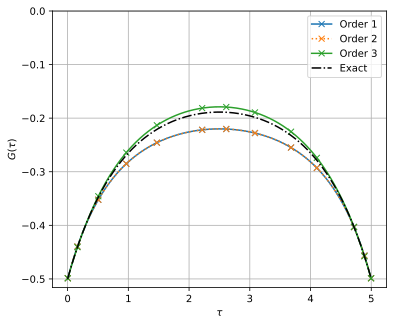

In [34]:
for r in results:
    plot_dlr_imtime(r.G_tau['0'], label=f'Order {r.order}', linestyle='-' if r.order != 2 else ':')

delta_tau = results[0].Delta_tau['0']
plot_dlr_imtime(delta_tau, label='Exact', marker='', linestyle='-.', color='black')

plt.ylabel(r'$G(\tau)$'); plt.xlabel(r'$\tau$')
plt.legend(loc='best'); plt.grid(True); plt.ylim(top=0);

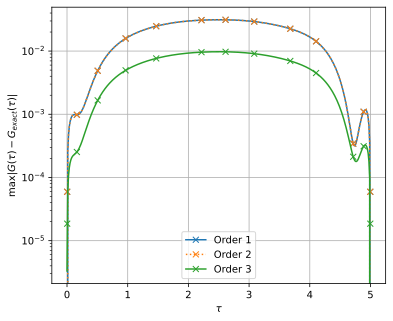

In [35]:
for r in results:
    diff_tau = delta_tau - r.G_tau['0']
    diff_tau.data[:] = np.abs(diff_tau.data)
    plot_dlr_imtime(diff_tau, label=f'Order {r.order}',
                    linestyle='-' if r.order != 2 else ':')

plt.semilogy([], [])
plt.legend(loc='best')

plt.ylabel(r'max$|G(\tau) - G_{exact}(\tau)|$')
plt.xlabel(r'$\tau$')
plt.grid(True)

We see that the convergence rate is fast an that the error at order 4 is about $10^{-3}$.